# Исследование объявлений о продаже квартир

Датасет содержит данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучение содержимого дата-сета 

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

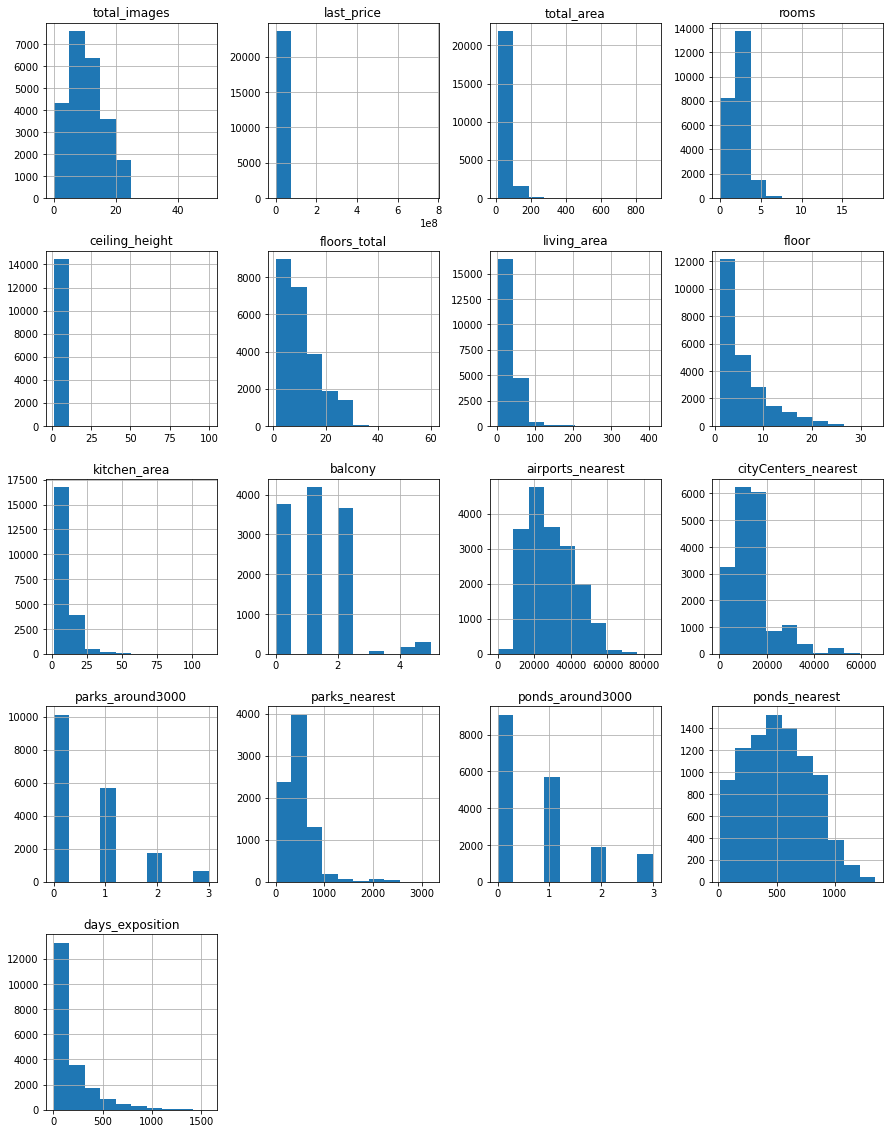

In [1]:
import pandas as pd
from collections import Counter
data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
#data.info()
print(data.head())
data.hist(figsize=(15, 20));
#print(len(data))

В таблице присутствуют пропуски, неверный тип данных(прим.: кол-во балконов и этажность с типом float). Еще, на мой взгляд, можно было бы перевести в целочисленный тип такие данные как расстояния до парков, аэропортов в целочисленный тип т.к. такая точность в данном случае лишняя. Названия населенных пунктов содержат неявные дубликаты, необходимо избавиться от них для дальшейшей работы с этим столбцом

### Предобработка данных

In [2]:
print(data.isna().sum())
#print(data.query('floors_total.isna()'))
#print(data.query('parks_around3000.isna()').tail())
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['floors_total'] = data['floors_total'].fillna(data['floor'])
data['is_apartment'] = data['is_apartment'].fillna('False')
data['living_area'] = data['living_area'].fillna(data['living_area'].median())
data['parks_nearest'] = data['parks_nearest'].fillna(data['parks_nearest'].median())
data['ponds_nearest'] = data['ponds_nearest'].fillna(data['ponds_nearest'].median())
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].median())
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median())
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())
data = data.dropna()
print(len(data))

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64
23650


К пропускам в данных ниже могли привести:
ceiling_height, floors_total, living_area - вносящий данные мог не знать точных данных
is_apartment - вносящий данные мог не понимать разницу между аппартаментами и жилой квартирой?
locality_name - мог не знать названия населенного пункта или поленился заполнить?
cityCenters_nearest - вероятно населенный пункт не является городом, что затрудняет определение у него центра
ponds_nearest, parks_nearest, airports_nearest - скорее всего указанных объект на столько далеко, что трудно будет определить расстояние до него 
ponds_around3000, parks_around3000 - скорее всего на расстоянии 3000 метров просто нет парков/прудов. В этом случае инчае как оставив поле пустым это отметить невозможно.



In [3]:
data.info()
data['last_price'] = data['last_price'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['airports_nearest'] = data['airports_nearest'].astype('int')
data['parks_nearest'] = data['parks_nearest'].astype('int')
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['ponds_nearest'] = data['ponds_nearest'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')
#print(data['is_apartment'].unique())
data['is_apartment'] = data['is_apartment'].astype('bool')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format = '%Y-%m-%dT%H:%M:%S')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Поля, тип данных которых был изменен:
last_price - изменен тип на целочисленный, т.к. после запятой в любом случае стояли 0
first_day_exposition - тип был изменен на datetime для упрощения работы с датами
floors_total - был изменен тип на целочисленный т.к. кол-во этажей не может быть дробным числом
is_apartment - в столбце значения только True-False, поэтому тип данных должен быть буливевым
balcony - изм. на целочисленный тип так, как кол-во балконов не может быть дробным числом
airports_nearest - изм. на целочисленный для упрощения подсчетов. обычно после точки все равно нули
cityCenters_nearest - изм. на целочисленный для упрощения подсчетов. обычно после точки все равно нули
parks_around3000 - изм. на целочисленный для упрощения подсчетов. обычно после точки все равно нули
parks_nearest - изм. на целочисленный для упрощения подсчетов. обычно после точки все равно нули
ponds_around3000 - изм. на целочисленный для упрощения подсчетов. обычно после точки все равно нули
ponds_nearest - изм. на целочисленный для упрощения подсчетов. обычно после точки все равно нули
days_exposition - изм. на целочисленный т.к. количество дней размещения не может быть дробным числом

In [4]:
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].astype('str')
tmp = []
tmp = '>'.join(data['locality_name'])
tmp = tmp.replace('посе','посё')
tmp = tmp.replace('городской посёлок','посёлок городского типа')
data['locality_name'] = tmp.split('>')
print(data['locality_name'].sort_values().unique())

['бокситогорск' 'волосово' 'волхов' 'всеволожск' 'выборг' 'высоцк'
 'гатчина' 'деревня агалатово' 'деревня аро' 'деревня батово'
 'деревня бегуницы' 'деревня белогорка' 'деревня большая вруда'
 'деревня большая пустомержа' 'деревня большие колпаны'
 'деревня большое рейзино' 'деревня большой сабск' 'деревня бор'
 'деревня борисова грива' 'деревня ваганово' 'деревня вартемяги'
 'деревня вахнова кара' 'деревня выскатка' 'деревня гарболово'
 'деревня глинка' 'деревня горбунки' 'деревня гостилицы'
 'деревня заклинье' 'деревня заневка' 'деревня зимитицы' 'деревня извара'
 'деревня иссад' 'деревня калитино' 'деревня кальтино' 'деревня камышовка'
 'деревня каськово' 'деревня келози' 'деревня кипень' 'деревня кисельня'
 'деревня колтуши' 'деревня коркино' 'деревня котлы' 'деревня кривко'
 'деревня кудрово' 'деревня кузьмолово' 'деревня курковицы'
 'деревня куровицы' 'деревня куттузи' 'деревня лаврики' 'деревня лаголово'
 'деревня лампово' 'деревня лесколово' 'деревня лопухинка'
 'деревня луппо

In [5]:
v#print(data.query('ceiling_height > 4.0'))
#print(data.query('ceiling_height < 1.0'))
data.loc[data['ceiling_height'] > 4, 'ceiling_height'] / 10
data.loc[data['kitchen_area'] > 20, 'kitchen_area'] / 10
data = data[data['ceiling_height'] < 4]v
data = data[data['kitchen_area'] < 20]

print(data['kitchen_area'].max(),data['kitchen_area'].min())
print(data['kitchen_area'].max(),data['kitchen_area'].min())
print(len(data))

19.94 1.3
19.94 1.3
22409


аномально большие значения в "ceiling_height": высота потолка не может быть 24 или 100 метров, 
"kitchen_area": пощадь кухни не может быть 45м

### Посчитайте и добавьте в таблицу новые столбцы

In [6]:
import datetime as dt
data['m_price'] = data['last_price']/data['total_area']
#print(dt.datetime.weekday(data['first_day_exposition']))
tmp = []
for i in data['first_day_exposition']:
    tmp.append(dt.datetime.weekday(i))
data['pub_day'] = tmp
data['pub_month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['pub_year'] = pd.DatetimeIndex(data['first_day_exposition']).year
tmp = []
for i in range(len(data)):
    if data['floor'].to_list()[i] == 1:
        tmp.append('первый')
    elif data['floor'].to_list()[i] == data['floors_total'].to_list()[i]:
        tmp.append('последний')
    else:
        tmp.append('другой')
data['floor_type'] = tmp
data['mc_distance'] = (data['cityCenters_nearest'] / 1000).astype('int')
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
5            10     2890000        30.4           2018-09-10      1   
6             6     3700000        37.3           2017-11-02      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
1            2.65            11         18.6      1          True  ...   
2            2.65             5         34.3      4          True  ...   
3            2.65            14         30.0      9          True  ...   
5            2.65            12         14.4      5          True  ...   
6            2.65            26         10.6      6          True  ...   

   parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
1            455                 0            502         

### Проведите исследовательский анализ данных

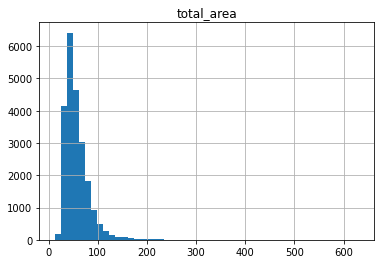

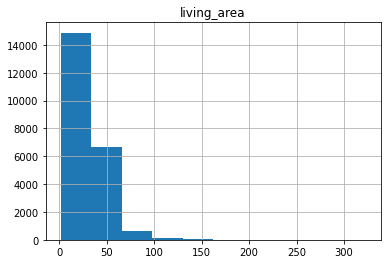

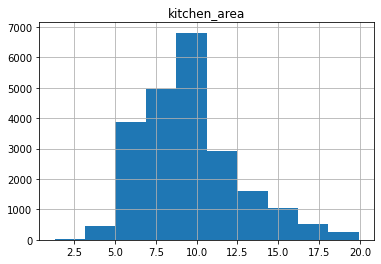

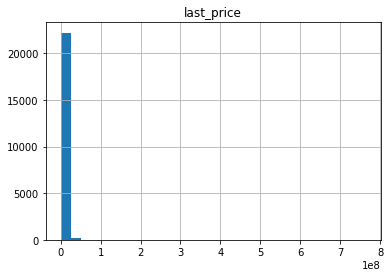

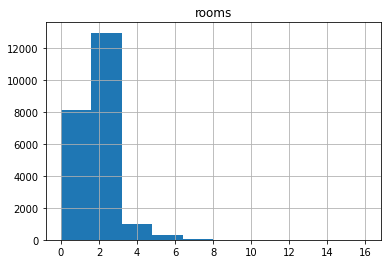

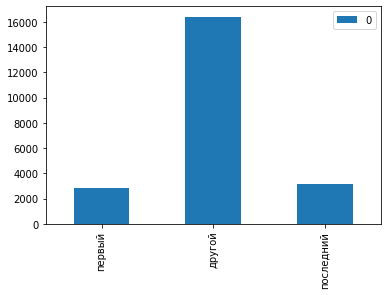

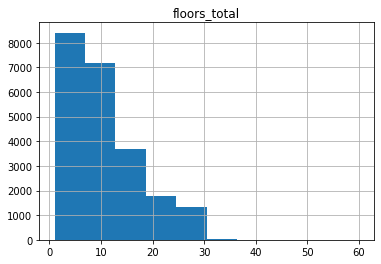

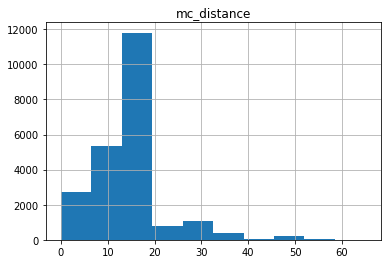

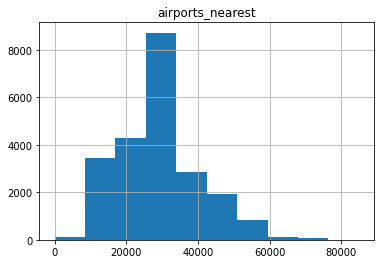

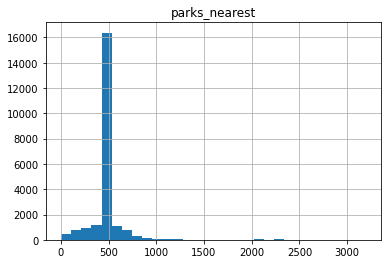

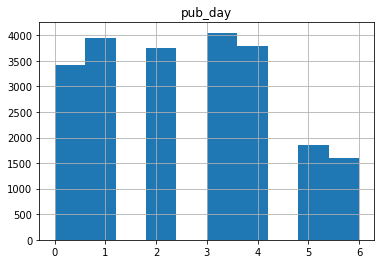

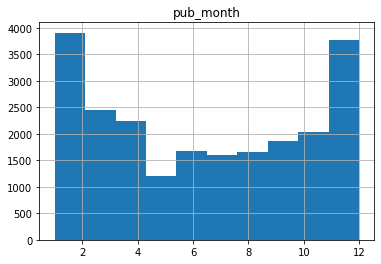

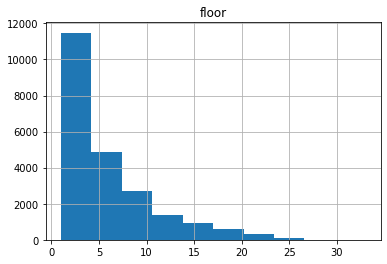

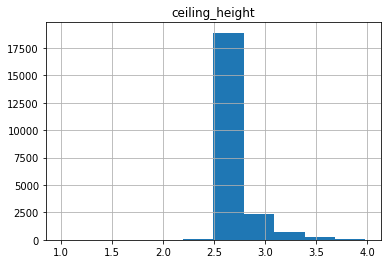

In [7]:
c = Counter(data['floor_type'])
df = pd.DataFrame.from_dict(c, orient='index')
data.hist('total_area',bins = 50)
data.hist('living_area');
data.hist('kitchen_area');
data.hist('last_price',bins = 30);
data.hist('rooms',bins = 10);
df.plot(kind='bar');
data.hist('floors_total');
data.hist('mc_distance');
data.hist('airports_nearest');
data.hist('parks_nearest',bins =30);
data.hist('pub_day',bins=10);
data.hist('pub_month');
data.hist('floor');
data.hist('ceiling_height');

total_area - чаще всего суммарная площадь квартиры составляет около 40м
living_area - жиая площадь чаще всего 30м
kitchen_area - зона кухни чаще всего около 9м
last_price - больше всего кваритр по цене около 400 000
rooms - больше всего 2х комнатных квартир
floor_type - квартир на первом и последнем этажах продается давольно мало, кол-во первых и последних этажей практически одинаковое
floors_total - больше всего пятиэтажных зданий
mc_distance - больше всего квартир находятся в 15км от центра города
airports_nearest - чаще всего расположение от аэропорта от 15 до 35 км
parks_nearest - чаще всего парки расположены 250-500м от квартиры
pub_day - чаще всего объявления публикуют в будние дни
pub_month - чаще всего объявления публикуют в начале года, в январе-феврале
floor - больше всего предложений по квартирам на 1-4 этажах
ceiling_height - высота потолков в осовном около 2.5м

95.0
166.53545450488642
1


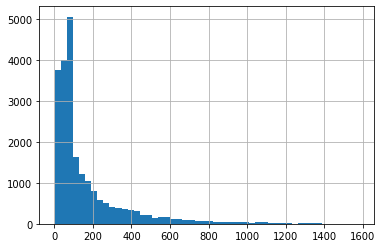

In [8]:
data['days_exposition'].hist(bins=50)
print(data['days_exposition'].median())
print(data['days_exposition'].mean())
print(data['days_exposition'].min())

В среднем продажа происходит в течение 170 дней после размещения
Анамально быстрыми продажами можно считать продажи в первую неделю 
Аномально медленными являются результаты выше 800 дней

0.58658324734301
0.47090969643388664
0.26963598633718966
0.33270827582359996


<AxesSubplot:xlabel='floor_type'>

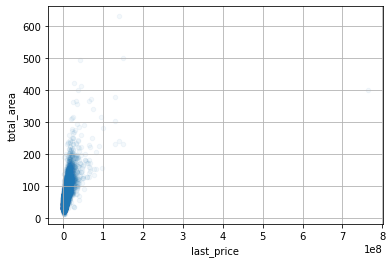

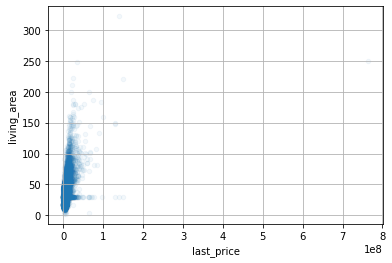

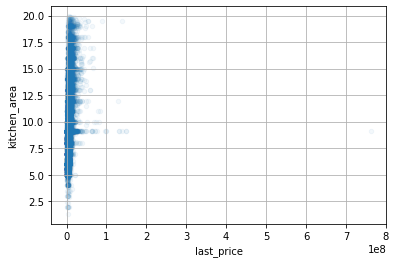

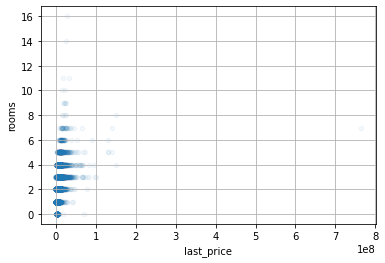

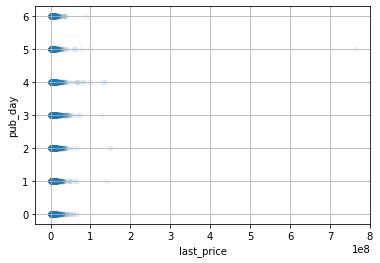

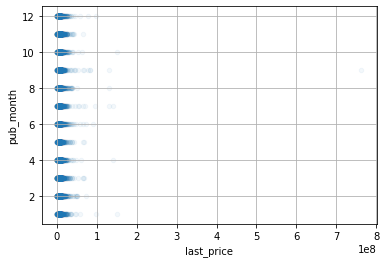

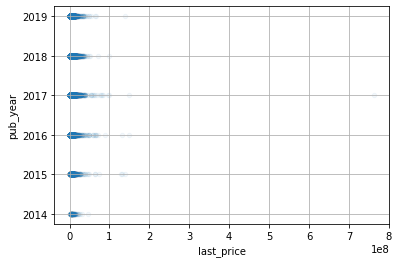

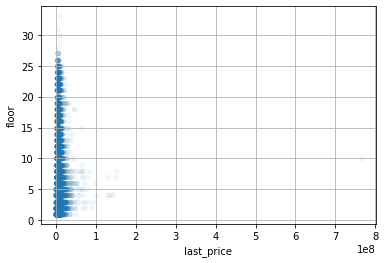

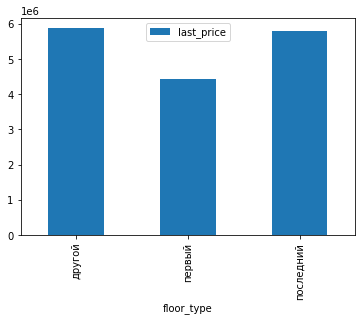

In [9]:
print(data['last_price'].corr(data['total_area']))
print(data['last_price'].corr(data['living_area']))
print(data['last_price'].corr(data['kitchen_area']))
print(data['last_price'].corr(data['rooms']))
data.plot(x='last_price', y='total_area', kind='scatter',alpha = 0.05, grid=True)
data.plot(x='last_price', y='living_area', kind='scatter',alpha = 0.05, grid=True)
data.plot(x='last_price', y='kitchen_area', kind='scatter',alpha = 0.05, grid=True)
data.plot(x='last_price', y='rooms', kind='scatter', alpha = 0.05, grid=True)
data.plot(x='last_price', y='pub_day', kind='scatter', alpha = 0.05, grid=True)
data.plot(x='last_price', y='pub_month', kind='scatter', alpha = 0.05, grid=True)
data.plot(x='last_price', y='pub_year', kind='scatter', alpha = 0.05, grid=True)
data.plot(x='last_price', y='floor', kind='scatter', alpha = 0.05, grid=True)
data.pivot_table(index='floor_type',values='last_price',aggfunc=['mean','median']).plot(y='mean',kind='bar')


чем больше суммарная площадь, тем выше цена/
чем больше жилая зона, тем выше цена/
размер кухонной зоны не сильно влияет на цену/
количество комнат не сильно влияет на цену/
день публикации не влияет на цену/
месяц публикации не влияет на цену/
год публикации не влияет на цену/
Квартиры на первом этаже дешевле, чем на последнем и других этажах

In [10]:
#print(data.pivot_table(index='locality_name',values='m_price',aggfunc='mean'))
top_10 = data['locality_name'].value_counts().head(10)
price = data.loc[data['locality_name'].isin(top_10.index)]
print(price.pivot_table(index='locality_name',values='m_price',aggfunc='mean'))

                         m_price
locality_name                   
всеволожск          68344.952583
выборг              57896.428373
гатчина             68623.614772
деревня кудрово     92956.527579
колпино             75350.495104
посёлок мурино      85652.120856
посёлок парголово   90136.007025
посёлок шушары      78663.561562
пушкин             101561.638985
санкт-петербург    110840.358995


Самая высокая стоимость кв. метра - Санкт-Петербург
Самая низкая стоимость кв. метра в Выборге

In [11]:
pd.options.mode.chained_assignment = None
spb = data[data['locality_name'] == "санкт-петербург"]
spb['mc_distance'] = spb['mc_distance'].round()
#spb_m = spb['m_price'].mean()
#spb.loc[:,'km_price'] = spb_m / spb['cityCenters_nearest']
#print(spb['km_price'].mean())
print(spb.pivot_table(index='mc_distance',values = 'm_price',aggfunc = ['mean','median']))

                      mean         median
                   m_price        m_price
mc_distance                              
0            142581.522531  123462.417080
1            146003.861948  118000.000000
2            131208.939313  111510.791367
3            124834.951651  106931.142548
4            130266.785037  122077.922078
5            136461.738222  121527.777778
6            141469.162869  127439.024390
7            132537.500409  122093.023256
8            117504.667935  112139.880952
9            109340.251563  104790.419162
10           109719.004976  104761.904762
11           106178.701808  103000.000000
12           107880.780058  103475.730288
13           107847.893443  104502.026636
14           104119.209889  101831.444554
15           101254.953317   98214.285714
16            99522.059929   97339.924670
17            93959.227006   91492.776886
18            94961.479918   93208.824996
19            94016.436811   92977.897252
20           106005.934546  106149

Стоимость квартиры напрямую зависит от ее отдаления от центра города. Чем ближе,тем дороже.

### Общий вывод

Из имеюихся данных были проведены исследования зависимостей таких характеристик продаваемых квартир как: влияние различных факторов на стоимость квартиры, на скорость ее продажи. На основании проведенных исследований мы можем сделать следующие выводы: Чем больше суммарная площадь, тем выше цена; чем больше жилая зона, тем выше цена; размер кухонной зоны не сильно влияет на цену; количество комнат не сильно влияет на цену; день публикации не влияет на цену; месяц публикации не влияет на цену; год публикации не влияет на цену; квартиры на первом этаже дешевле, чем на последнем и других этажах; cтоимость квартиры напрямую зависит от ее отдаления от центра города. Чем ближе,тем дороже; 
total_area - чаще всего суммарная площадь квартиры составляет около 40м
living_area - жиая площадь чаще всего 30м
kitchen_area - зона кухни чаще всего около 9м
last_price - больше всего кваритр по цене около 400 000
rooms - больше всего 2х комнатных квартир
floor_type - квартир на первом и последнем этажах продается давольно мало, кол-во первых и последних этажей практически одинаковое
floors_total - больше всего пятиэтажных зданий
mc_distance - больше всего квартир находятся в 15км от центра города
airports_nearest - чаще всего расположение от аэропорта от 15 до 35 км
parks_nearest - чаще всего парки расположены 250-500м от квартиры
pub_day - чаще всего объявления публикуют в будние дни
pub_month - чаще всего объявления публикуют в начале года, в январе-феврале
floor - больше всего предложений по квартирам на 1-4 этажах
ceiling_height - высота потолков в осовном около 2.5м